## Dependencies

In [1]:
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

import torch_geometric.transforms as T
from torch_geometric.datasets import SNAPDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv
from torch_geometric.utils import negative_sampling, to_networkx

torch.manual_seed(0)

%matplotlib notebook

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

orig_transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
])

transform = T.Compose([
    T.ToDevice(device),
    T.RemoveIsolatedNodes(),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        add_negative_train_samples=False
    ),
])

orig_dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=orig_transform)
dataset = SNAPDataset(root="../data/SNAPDataset", name="ego-facebook", transform=transform)

data = orig_dataset[0]
train_data, val_data, test_data = dataset[0]

In [3]:
print(data)
print(train_data)
print(val_data)
print(test_data)

Data(x=[347, 1406], edge_index=[2, 5718], circle=[325], circle_batch=[325])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[2432], edge_label_index=[2, 2432])
Data(x=[347, 1406], edge_index=[2, 4864], circle=[325], circle_batch=[325], edge_label=[284], edge_label_index=[2, 284])
Data(x=[347, 1406], edge_index=[2, 5148], circle=[325], circle_batch=[325], edge_label=[570], edge_label_index=[2, 570])


## Prediction

In [4]:
from torch import nn
import torch.nn.functional as F


class SimpleNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    
    def forward(self, x, edge_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_index)
        return torch.hstack((-out, out)).T


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # TODO: look into SAGEConv, GATConv, GINConv, comparison between
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        self.W1 = nn.Linear(out_channels * 2, out_channels)
        self.W2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        z1 = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), dim=1)
        out1 = self.W2(F.relu(self.W1(z1)).squeeze())
        
        z2 = torch.cat((z[edge_label_index[1]], z[edge_label_index[0]]), dim=1)
        out2 = self.W2(F.relu(self.W1(z2)).squeeze())
        
        return (out1 + out2) / 2
    
    def forward(self, x, edge_index, edge_label_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_label_index)
        return torch.hstack((-out, out)).T

simple_model = SimpleNet(dataset.num_features, 128, 32).to(device)
simple_optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=3e-3)
    
model = Net(dataset.num_features, 128, 32).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# TODO: These methods simultaneously use node feature and graph structure properties.
#       Is it possible to train models that look at each aspect separately
#       Can look at only node features by just passing original layer to MLP
#       Unsure if can look at only graph by passing random vector into GCNConv
#       Should also read up on Node2Vec and other methods of generating node embeddings (talk to Rex)

In [5]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index, 
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.shape[1], 
        method='sparse'
    )
    
    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([data.edge_label, data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    a, b = data.edge_label.cpu().numpy(), out.cpu().numpy()
    c = (out > 0.5).float().cpu().numpy()
    return roc_auc_score(a, b), accuracy_score(a, c)

In [6]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(simple_model, simple_optimizer, train_data)
    val_auc, val_acc = test(simple_model, val_data)
    test_auc, test_acc = test(simple_model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

simple_z = simple_model.encode(test_data.x, test_data.edge_index)
simple_final_edge_index = simple_model.decode(simple_z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4914, Val: 0.9214 0.7324, Test: 0.9004 0.7614
Epoch: 100, Loss: 0.4645, Val: 0.9384 0.7500, Test: 0.9045 0.7526
Epoch: 150, Loss: 0.4450, Val: 0.9328 0.7465, Test: 0.9036 0.7614
Epoch: 200, Loss: 0.4303, Val: 0.9314 0.7430, Test: 0.8980 0.7526
Epoch: 250, Loss: 0.4339, Val: 0.9263 0.7570, Test: 0.8927 0.7509
Epoch: 300, Loss: 0.4294, Val: 0.9190 0.7500, Test: 0.8885 0.7596
Epoch: 350, Loss: 0.4298, Val: 0.9178 0.7500, Test: 0.8911 0.7649
Epoch: 400, Loss: 0.4232, Val: 0.9140 0.7394, Test: 0.8801 0.7649
Epoch: 450, Loss: 0.4301, Val: 0.9168 0.7641, Test: 0.8825 0.7684
Epoch: 500, Loss: 0.4123, Val: 0.9094 0.7500, Test: 0.8749 0.7667
Epoch: 550, Loss: 0.4013, Val: 0.9089 0.7606, Test: 0.8775 0.7737
Epoch: 600, Loss: 0.4060, Val: 0.9103 0.7430, Test: 0.8743 0.7667
Epoch: 650, Loss: 0.4455, Val: 0.9037 0.7641, Test: 0.8693 0.7789
Epoch: 700, Loss: 0.4035, Val: 0.9055 0.7676, Test: 0.8707 0.7614
Epoch: 750, Loss: 0.4128, Val: 0.9076 0.7641, Test: 0.8742 0.7702
Epoch: 800

In [7]:
best_val_auc = final_test_auc = final_test_acc = 0
for epoch in range(1, 1001):
    loss = train(model, optimizer, train_data)
    val_auc, val_acc = test(model, val_data)
    test_auc, test_acc = test(model, test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        final_test_acc = test_acc
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} {val_acc:.4f}, Test: {test_auc:.4f} {test_acc:.4f}')

print(f'Final Test: {final_test_auc:.4f} {final_test_acc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode(z, test_data.edge_label_index)

Epoch: 050, Loss: 0.4091, Val: 0.9129 0.8556, Test: 0.8999 0.8211
Epoch: 100, Loss: 0.3157, Val: 0.9382 0.8662, Test: 0.9375 0.8632
Epoch: 150, Loss: 0.2901, Val: 0.9460 0.8768, Test: 0.9458 0.8684
Epoch: 200, Loss: 0.2590, Val: 0.9486 0.8768, Test: 0.9467 0.8737
Epoch: 250, Loss: 0.2691, Val: 0.9496 0.8768, Test: 0.9470 0.8807
Epoch: 300, Loss: 0.2457, Val: 0.9512 0.9085, Test: 0.9466 0.8860
Epoch: 350, Loss: 0.2503, Val: 0.9512 0.8838, Test: 0.9471 0.8877
Epoch: 400, Loss: 0.2491, Val: 0.9523 0.8908, Test: 0.9473 0.8895
Epoch: 450, Loss: 0.2517, Val: 0.9536 0.8873, Test: 0.9476 0.8842
Epoch: 500, Loss: 0.2364, Val: 0.9533 0.8838, Test: 0.9472 0.8825
Epoch: 550, Loss: 0.2395, Val: 0.9554 0.8873, Test: 0.9465 0.8842
Epoch: 600, Loss: 0.2387, Val: 0.9570 0.8944, Test: 0.9452 0.8842
Epoch: 650, Loss: 0.2274, Val: 0.9582 0.8627, Test: 0.9450 0.8632
Epoch: 700, Loss: 0.2149, Val: 0.9587 0.9049, Test: 0.9446 0.8842
Epoch: 750, Loss: 0.2176, Val: 0.9594 0.9014, Test: 0.9453 0.8842
Epoch: 800

In [8]:
(test_data.edge_label == (torch.sigmoid(simple_final_edge_index.squeeze()) > 0.7)).sum() / test_data.edge_label.shape[0]

tensor(0.8509)

In [9]:
(test_data.edge_label == (torch.sigmoid(final_edge_index.squeeze()) > 0.5)).sum() / test_data.edge_label.shape[0]

tensor(0.8930)

In [10]:
simple_model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[ 0.9216,  0.3921,  1.2110,  ...,  2.1181,  0.9543,  1.0145],
        [-0.9216, -0.3921, -1.2110,  ..., -2.1181, -0.9543, -1.0145]],
       grad_fn=<PermuteBackward0>)

In [11]:
model.forward(test_data.x, test_data.edge_index, test_data.edge_label_index)

tensor([[ -7.6873,  -1.2435,  -1.3025,  ...,   2.7672,  11.1813,   4.9264],
        [  7.6873,   1.2435,   1.3025,  ...,  -2.7672, -11.1813,  -4.9264]],
       grad_fn=<PermuteBackward0>)

## Exploration

In [12]:
test_data.edge_label_index[:, 5]

tensor([179, 186])

In [13]:
node_1 = 179
node_2 = 186

node_1_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_1)][1].cpu().numpy())
node_2_neighbors = set(test_data.edge_index[:, (test_data.edge_index[0] == node_2)][1].cpu().numpy())

print("Node 1 Neighbors:", node_1_neighbors)
print("Node 2 Neighbors:", node_2_neighbors)
print("Overlapping Neighbors:", node_1_neighbors.intersection(node_2_neighbors))

Node 1 Neighbors: {193, 195, 100, 4, 298, 203, 301, 47, 79, 241, 52, 93, 23, 248, 345, 346, 91, 253}
Node 2 Neighbors: {4, 265, 298, 301, 79, 241, 93, 23, 248, 345, 346, 253}
Overlapping Neighbors: {4, 298, 301, 79, 241, 23, 248, 345, 346, 93, 253}


<IPython.core.display.Javascript object>


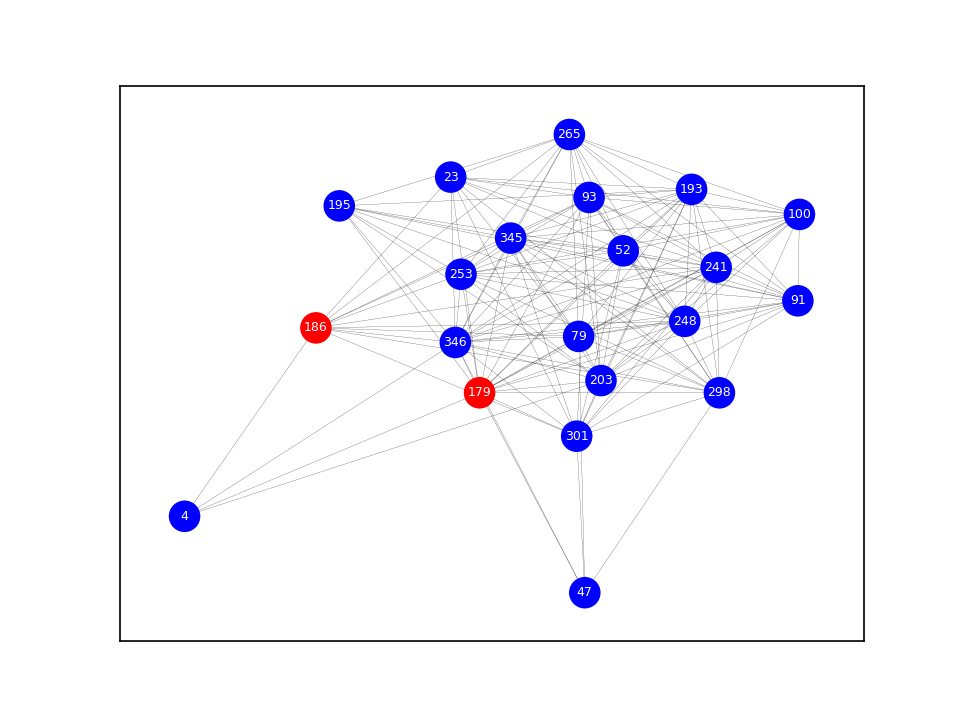

In [14]:
nodes = [node_1, node_2] + list(node_1_neighbors.union(node_2_neighbors))
colors = ["red", "red"] + ["blue" for _ in nodes[2:]]

fig, ax = plt.subplots()
g = to_networkx(test_data, to_undirected=True)
h = g.subgraph(nodes)
nx.draw_networkx(h, node_size=200, nodelist=nodes, node_color=colors, width=0.1, font_color="white", font_size=6)
plt.show()

In [15]:
old_z = model.encode(test_data.x, test_data.edge_index)
old_pred = model.decode(old_z, torch.tensor([[node_1], [node_2]]))
print(old_pred)

tensor([2.4242], grad_fn=<DivBackward0>)


In [16]:
for neighbor in node_1_neighbors.union(node_2_neighbors):
    temp_x = test_data.x.clone()
    temp_x[neighbor] = 0
    new_z = model.encode(temp_x, test_data.edge_index)
    new_pred = model.decode(new_z, torch.tensor([[node_1], [node_2]]))
    print(neighbor, "\t", round(new_pred.item(), 5))

193 	 2.16357
195 	 2.32113
4 	 2.34079
265 	 2.25905
203 	 2.11491
79 	 2.40932
23 	 2.37247
345 	 1.97552
346 	 2.26424
91 	 2.37924
93 	 2.32134
100 	 2.27589
298 	 2.26643
301 	 2.33442
47 	 2.28713
241 	 2.42545
52 	 2.41025
248 	 2.41812
253 	 2.37793


In [17]:
# Start implementing GNNExplainer, PGExplainer, and SubgraphX architectures with 1-hop subgraph as parameters
# Think about separately learning node feature explanations

## GNNExplainer

In [18]:
from math import sqrt

from torch_geometric.nn import GNNExplainer
from torch_geometric.nn.models.explainer import clear_masks, set_masks
from torch_geometric.utils import k_hop_subgraph

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    coeffs = {
        'edge_size': 0.25,  # 0.005
        'edge_reduction': 'sum',  # sum
        'edge_ent': 1.0,  # 1.0
    }
    
    def _initialize_masks(self, x, edge_index, sub_edge_mask=None, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)
        self.node_feat_mask = torch.nn.Parameter(100 * torch.ones(1, F))
        
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        if sub_edge_mask is None:
            self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)
        else:
            E_1, mask = sub_edge_mask.sum(), 100 * torch.ones(E)
            mask[sub_edge_mask] = torch.randn(E_1) * std
            self.edge_mask = torch.nn.Parameter(mask)
            
    def _loss(self, log_logits, prediction, node_idx = None):
        error_loss = -log_logits[prediction]
                
        m = self.edge_mask[self.sub_edge_mask].sigmoid()
        edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
        edge_size_loss = edge_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        edge_ent_loss = ent.mean()

        loss = (
            error_loss + 
            self.coeffs['edge_size'] * edge_size_loss + 
            self.coeffs['edge_ent'] * edge_ent_loss
        )
        
        print(
            round(error_loss.item(), 4), "  \t", 
            round(edge_size_loss.item(), 4), "  \t", 
            round(edge_ent_loss.item(), 4), "  \t",
            round(loss.item(), 4), "  \t"
        )
        
        return loss
    
    def subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        subset_1, edge_index_1, _, edge_mask_1 = k_hop_subgraph(
            node_idx_1, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        subset_2, edge_index_2, _, edge_mask_2 = k_hop_subgraph(
            node_idx_2, self.num_hops, edge_index, num_nodes=num_nodes, flow=self._flow()
        )
        
        # Combines two node-centered subgraphs
        temp_node_idx = edge_index[0].new_full((num_nodes,), -1)  # full size
        edge_mask = edge_mask_1 | edge_mask_2
        edge_index = edge_index[:, edge_mask]  # filters out edges
        subset = torch.cat((subset_1, subset_2)).unique()
        temp_node_idx[subset] = torch.arange(subset.size(0), device=edge_index.device)
        edge_index = temp_node_idx[edge_index]  # maps edge_index to [0, n]
        x = x[subset]  # filters out nodes
        mapping = torch.tensor([
            (subset == node_idx_1).nonzero().item(), 
            (subset == node_idx_2).nonzero().item(),
        ])
        
        # Only optimizes the edges from neighbors to node_1/node_2, other direction not needed for prediction
        sub_edge_mask = (edge_index[1] == mapping[0]) |  (edge_index[1] == mapping[1])
        
        return x, edge_index, mapping, edge_mask, subset, sub_edge_mask
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes, num_edges = x.size(0), edge_index.size(1)
        
        # Only operate on a k-hop subgraph around `node_idx_1` and `node_idx_2.
        x, edge_index, mapping, hard_edge_mask, subset, sub_edge_mask = \
            self.subgraph(node_idx_1, node_idx_2, x, edge_index)
        self.sub_edge_mask = sub_edge_mask
        edge_label_index=mapping.unsqueeze(1)
        
        # Get the initial prediction
        prediction = self.get_initial_prediction(x, edge_index, edge_label_index=edge_label_index)
        
        self._initialize_masks(x, edge_index, sub_edge_mask)
        self.to(x.device)

        set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
        optimizer = torch.optim.Adam([self.edge_mask], lr=self.lr)

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x=x, edge_index=edge_index, edge_label_index=edge_label_index)
            loss = self.get_loss(out, prediction, mapping).mean()
            loss.backward()
            optimizer.step()

        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        
        self._clear_masks()

        return edge_mask

In [19]:
x = test_data.x
edge_index = test_data.edge_index

node_idx_1 = node_1  # test_data.edge_label_index[0, 0].item()
node_idx_2 = node_2  # test_data.edge_label_index[1, 0].item()

print(node_idx_1, node_idx_2)

explainer = EdgeGNNExplainer(model, epochs=200, lr=0.1)
edge_mask = explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

print("Done!")

179 186
1.0837   	 14.8875   	 0.6925   	 5.4981   	
1.0433   	 14.6883   	 0.6907   	 5.406   	
1.039   	 14.5918   	 0.6877   	 5.3747   	
1.0271   	 14.5265   	 0.6839   	 5.3427   	
1.0435   	 14.479   	 0.6793   	 5.3426   	
1.0252   	 14.516   	 0.6772   	 5.3313   	
0.9716   	 14.5903   	 0.6765   	 5.2957   	


C:\Users\Abhijit\AppData\Local\Temp\ipykernel_19712\81617139.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2985.)
  return torch.hstack((-out, out)).T


0.907   	 14.6867   	 0.6767   	 5.2554   	
0.8699   	 14.775   	 0.6757   	 5.2393   	
0.8331   	 14.8567   	 0.6738   	 5.2211   	
0.7968   	 14.9331   	 0.671   	 5.2011   	
0.7609   	 15.0048   	 0.6676   	 5.1797   	
0.7255   	 15.0727   	 0.6636   	 5.1573   	
0.6907   	 15.1373   	 0.6589   	 5.1339   	
0.6566   	 15.1989   	 0.6536   	 5.11   	
0.6238   	 15.2568   	 0.6479   	 5.0859   	
0.592   	 15.3114   	 0.6416   	 5.0614   	
0.5612   	 15.3628   	 0.6348   	 5.0367   	
0.5313   	 15.4115   	 0.6276   	 5.0118   	
0.5052   	 15.4575   	 0.62   	 4.9896   	
0.4702   	 15.5301   	 0.6131   	 4.9659   	
0.44   	 15.5973   	 0.6058   	 4.9452   	
0.4064   	 15.6842   	 0.5992   	 4.9266   	
0.3751   	 15.7639   	 0.592   	 4.9081   	
0.3454   	 15.8371   	 0.5844   	 4.8891   	
0.3172   	 15.9046   	 0.5764   	 4.8698   	
0.2903   	 15.967   	 0.5682   	 4.8503   	
0.2648   	 16.0248   	 0.5597   	 4.8306   	
0.2404   	 16.0785   	 0.5509   	 4.811   	
0.2172   	 16.1286   	 

-0.2554   	 17.1605   	 0.0489   	 4.0836   	
-0.2561   	 17.1629   	 0.0487   	 4.0834   	
-0.2564   	 17.1638   	 0.0485   	 4.0831   	
-0.2562   	 17.1634   	 0.0482   	 4.0828   	
-0.2567   	 17.1649   	 0.048   	 4.0825   	
-0.2576   	 17.1682   	 0.0478   	 4.0823   	
-0.258   	 17.17   	 0.0476   	 4.0821   	
-0.2582   	 17.1702   	 0.0474   	 4.0818   	
-0.258   	 17.1692   	 0.0471   	 4.0814   	
-0.2583   	 17.1702   	 0.0468   	 4.0811   	
-0.259   	 17.1732   	 0.0467   	 4.081   	
Done!


In [20]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_2)], edge_mask[(edge_index[1] == node_idx_2)])
).T

tensor([[2.3000e+01, 3.8078e-03],
        [4.0000e+00, 9.9682e-01],
        [9.3000e+01, 9.8795e-01],
        [7.9000e+01, 9.8829e-01],
        [3.0100e+02, 9.8600e-01],
        [2.5300e+02, 9.9475e-01],
        [3.4600e+02, 2.9349e-03],
        [2.4100e+02, 3.0354e-03],
        [2.6500e+02, 9.9478e-01],
        [2.4800e+02, 6.0077e-03],
        [3.4500e+02, 9.9566e-01],
        [2.9800e+02, 9.9433e-01]])

In [21]:
torch.vstack(
    (edge_index[0, (edge_index[1] == node_idx_1)], edge_mask[(edge_index[1] == node_idx_1)])
).T

tensor([[4.7000e+01, 9.9784e-01],
        [1.0000e+02, 9.9681e-01],
        [2.3000e+01, 3.3210e-03],
        [7.9000e+01, 9.9657e-01],
        [5.2000e+01, 3.1933e-03],
        [4.0000e+00, 9.9738e-01],
        [9.3000e+01, 3.5382e-03],
        [9.1000e+01, 2.0981e-01],
        [3.4500e+02, 9.9682e-01],
        [1.9500e+02, 9.9723e-01],
        [2.4100e+02, 3.8107e-03],
        [2.0300e+02, 8.4438e-03],
        [2.9800e+02, 9.9701e-01],
        [3.0100e+02, 6.8185e-03],
        [2.5300e+02, 9.9591e-01],
        [1.9300e+02, 9.9664e-01],
        [3.4600e+02, 2.6382e-03],
        [2.4800e+02, 6.3982e-03]])

Methods to produce explanations
- GNNExplainer with the prediction model outputting probability, optimizing edge weights directed into node 1/2
  - Need to look into better combination of loss terms
  - Should explore using separate node embedding regression explanation
  - (To isolate graph explanation) can potentially set node 1/2 features to 0, or remove edges from node 1/2 (preferred?)
- SubgraphX variants (including just using 'Algorithm 2' on each of the candidate nodes, since the subgraph tree concept is less applicable)